# 🧩 Merge Conflict Prediction - Scikit-learn Implementation

**Key focus**: Maximizing precision to minimize false pozitives while still identifying potential conflicts.

# 🔍 Setup and Data Loading

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
print("🔄 Loading dataset...")
df = pd.read_csv('MergeConflictsDataset.csv', sep=';')
display(df.head())
df.info()

🔄 Loading dataset...


,commit,parent1,parent2,ancestor,is pr,added lines,deleted lines,devs parent1,devs parent2,time,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
0,efc0bcd1d6199448c323549fdc45310750b48c85,fb9f2a65cabba5a924b89a45793914066471b2ab,5ee7c7c750e9ecffaea12f97d5b05b2445e7c007,fb9f2a65cabba5a924b89a45793914066471b2ab,1,5,0,0,1,23,...,0,0,0,0,0,20,65,35.40000,20.0,0
1,287b9b838b6b6b212ef538aa537aef76110ee111,72fd7d81c9c7e28af8740f5a1b210a803290383d,fb9f2a65cabba5a924b89a45793914066471b2ab,a18c1088c892f1e6ed4b7d541e68b2e4b039a42e,0,1166,11267,1,2,371,...,0,0,0,0,0,31,117,58.56383,53.5,1
2,e7478680c0db825239ea9628967728c8577bb5c2,36977963caa2896ad9a4a92b2bdcd85189beccb1,bc230857adc3a9763bc7d89793d826463c857c00,36977963caa2896ad9a4a92b2bdcd85189beccb1,1,0,0,0,1,22,...,0,0,0,0,0,18,18,18.00000,18.0,0
3,0c65b30a8fd3a7db40163fcb9b0004cb7487c0ff,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,877c43f8242b88447d0234400c6e9b5c7586b558,fe29962932a8e34f0c3ac5cd795cd40090c9fabd,1,0,0,2,1,24,...,0,0,0,0,0,22,63,38.80000,31.0,0
4,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,7899f565d3461ed287e61662c8d399aafcac9e42,5e68e04e310c4f57a19d4cfa6be1e0ba3a8801d6,236b85af833398e0f07d08b7d7a25734d8c1b11d,0,0,0,1,2,2,...,0,0,0,0,0,31,56,43.50000,43.5,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26973 entries, 0 to 26972
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   commit           26973 non-null  object 
 1   parent1          26973 non-null  object 
 2   parent2          26973 non-null  object 
 3   ancestor         26972 non-null  object 
 4   is pr            26973 non-null  int64  
 5   added lines      26973 non-null  int64  
 6   deleted lines    26973 non-null  int64  
 7   devs parent1     26973 non-null  int64  
 8   devs parent2     26973 non-null  int64  
 9   time             26973 non-null  int64  
 10  nr files         26973 non-null  int64  
 11  added files      26973 non-null  int64  
 12  deleted files    26973 non-null  int64  
 13  renamed files    26973 non-null  int64  
 14  copied files     26973 non-null  int64  
 15  modified files   26973 non-null  int64  
 16  nr commits1      26973 non-null  int64  
 17  nr commits2 

In [3]:
print("\nClass distribution (conflict vs. no conflict):")
conflict_counts = df['conflict'].value_counts()
print(conflict_counts)
print(f"Conflict rate: {conflict_counts[1] / len(df):.2%}")


Class distribution (conflict vs. no conflict):
conflict
0    25505
1     1468
Name: count, dtype: int64
Conflict rate: 5.44%


# 🧹 Data Preprocessing


We separate commit metadata (IDs, hashes) from actual predictive features. Commit IDs are unique identifiers that provide no generalizable patterns for future predictions.

To ensure the dataset is clean and ready for model training, we:
- Handled missing values
- Normalized feature values using `StandardScaler`
- Used SMOTE to address class imbalance, which is crucial for improving recall
- Split the data into training and test sets (stratified to maintain class distribution)

This ensures that models are trained on balanced and scaled data, which helps performance.

In [4]:
non_feature_cols = ['commit', 'parent1', 'parent2', 'ancestor']
feature_cols = [col for col in df.columns if col not in non_feature_cols and col != 'conflict']

X = df[feature_cols]
y = df['conflict']

missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values per column:")
    print(missing_values[missing_values > 0])
    df.dropna(inplace=True) 
    print("Dropped rows with missing values.")
else:
    print("\n ✅ No missing values in the dataset.")


Missing values per column:
ancestor    1
dtype: int64
Dropped rows with missing values.


# 🔀 Train/Test Split with Stratification

Due to the significant class imbalance (5.44% conflicts), stratification is essential in our train/test split.

**Stratification was crucial because:**
- Without stratification, random sampling might result in too few conflict examples in the test set
- This would make evaluation unreliable and potentially misleading
- Stratification ensures both training and test sets maintain the same class distribution

We use an 80/20 train/test split with stratification on the target variable. The result confirms identical conflict ratios in both sets (5.44%), providing a solid foundation for model training and evaluation.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training set conflict ratio: {100 * y_train.mean():.2f}%")
print(f"Test set conflict ratio: {100 * y_test.mean():.2f}%")


Training set shape: (21578, 32), Test set shape: (5395, 32)
Training set conflict ratio: 5.44%
Test set conflict ratio: 5.45%


# 🔢 Feature Scaling

Many features in our dataset have dramatically different scales:
- 📊 Line additions/deletions range from 0 to over 1,140,000
- ⏱️ Time duration ranges from 0 to over 21,000 hours
- 👥 Developer counts range from 1 to hundreds

Without scaling, features with larger values would dominate the learning process, biasing our models toward these numerically larger features regardless of their actual importance. StandardScaler transforms all features to have zero mean and unit variance, ensuring fair comparison between features.

> 📝 **Note**: We fit the scaler ONLY on the training data, then apply that transformation to the test data. This prevents data leakage, where information from the test set would influence the training process. 

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test) 

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nFeature ranges after scaling (training data):")
for feature in ['added lines', 'deleted lines', 'time', 'nr files', 'modified files']:
    print(f"{feature}: Min={X_train_scaled[feature].min():.2f}, Max={X_train_scaled[feature].max():.2f}, Mean={X_train_scaled[feature].mean():.2f}, StdDev={X_train_scaled[feature].std():.2f}")



Feature ranges after scaling (training data):
added lines: Min=-0.07, Max=112.16, Mean=0.00, StdDev=1.00
deleted lines: Min=-0.02, Max=99.56, Mean=0.00, StdDev=1.00
time: Min=-0.27, Max=24.11, Mean=0.00, StdDev=1.00
nr files: Min=-0.09, Max=65.31, Mean=-0.00, StdDev=1.00
modified files: Min=-0.11, Max=58.78, Mean=0.00, StdDev=1.00


# 📏 Performance Metric Selection

Due to severe class imbalance (5.44% conflicts vs. 94.56% non-conflicts):

1. Accuracy is misleading: A model always predicting "no conflict" would achieve 94.56% accuracy, but would provide no value for detecting conflicts.

2. Better metrics for imbalanced classification:
   - Precision: Proportion of predicted conflicts that are actually conflicts - important to minimize false alarms
   - Recall: Proportion of actual conflicts that were correctly identified - important to catch actual conflicts
   - F1-score: The harmonic mean of precision and recall- balances the trade-off between false positives and false negatives

3. Training vs. Test Performance Gap: By comparing metrics between training and test sets, we can identify potential overfitting or underfitting issues.

For merge conflict prediction:
1. High recall is valuable as missing conflicts can be costly
2. However, too many false alarms (low precision) can lead to alert fatigue
3. F1-score provides a balanced perspective on model performance
4. Ensemble methods (Random Forest, AdaBoost) typically perform best

In [7]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    if not hasattr(model, 'classes_'):
        model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred)
    }
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }
    
    print(f"\n{model_name} Evaluation:")
    print("Training Set Metrics:")
    for metric, value in train_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    print("\nTest Set Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")
    
    print("\nOverfitting Analysis:")
    for metric in train_metrics:
        diff = train_metrics[metric] - test_metrics[metric]
        print(f"  {metric} difference (train-test): {diff:.4f}")
    
    if train_metrics['precision'] - test_metrics['precision'] > 0.1:
        print("⚠️ Warning: Potential overfitting detected in precision metric")
    elif test_metrics['precision'] < 0.6:
        print("⚠️ Warning: Model may be underfitting (low precision)")
    else:
        print("✅ Model shows good fit for precision")
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.show()
    
    return model, train_metrics, test_metrics

# 🔎 Feature Selection 

With 32 original features, feature selection provides multiple benefits:

1. **Dimensionality Reduction**: Removing noise from irrelevant features improves model generalization
2. **Improved Interpretability**: Fewer features make the model easier to understand and explain
3. **Reduced Computational Cost**: Training time decreases with fewer features
4. **Domain Insights**: Identifying truly important features provides practical knowledge for developers

We used Random Forest importance with balanced class weights because:
- It captures both linear and non-linear relationships with the target
- It naturally handles feature interactions
- The balanced class weights ensure importance measures aren't biased by the majority class
- It's more stable than single-tree methods like decision trees

The feature importance plot reveals that a small subset of features (top 10) captures most of the predictive power, allowing us to significantly simplify our models without loss of performance.

In [8]:
print("\nPerforming feature selection...")

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)  

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFeature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. {feature_cols[indices[f]]} ({importances[indices[f]]:.5f})")


Performing feature selection...

Feature ranking:
1. nr files (0.28852)
2. is pr (0.25897)
3. nr commits1 (0.06800)
4. devs parent1 (0.05282)
5. nr commits2 (0.05075)
6. add (0.02891)
7. devs parent2 (0.02760)
8. messages_min (0.02649)
9. added lines (0.02357)
10. messages_mean (0.01790)
11. deleted lines (0.01643)
12. messages_median (0.01579)
13. modified files (0.01519)
14. time (0.01438)
15. messages_max (0.01420)
16. fix (0.01307)
17. density2 (0.01085)
18. density1 (0.00776)
19. update (0.00699)
20. remove (0.00615)
21. change (0.00576)
22. use (0.00452)
23. refactor (0.00426)
24. added files (0.00418)
25. bug (0.00415)
26. improve (0.00378)
27. document (0.00236)
28. feature (0.00192)
29. renamed files (0.00186)
30. deleted files (0.00162)
31. delete (0.00123)
32. copied files (0.00000)


In [9]:
top_features = 10
selected_features = [feature_cols[i] for i in indices[:top_features]]
print(f"\nSelected top {top_features} features:")
print(selected_features)

X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]


Selected top 10 features:
['nr files', 'is pr', 'nr commits1', 'devs parent1', 'nr commits2', 'add', 'devs parent2', 'messages_min', 'added lines', 'messages_mean']


## 🔄 SMOTE for Class Balance

**SMOTE** (Synthetic Minority Over-sampling Technique) addresses our class imbalance by:

1. 🔍 **Identifying** minority class samples (conflicts in our case)
2. 🧮 **Creating** synthetic examples by interpolating between existing minority instances
3. ⚖️ **Balancing** the dataset so both classes have equal representation

This technique is particularly valuable for our conflict prediction task because:
- It preserves the characteristics of real conflicts while creating variations
- It gives the model sufficient examples to learn the patterns of conflict-prone merges
- It prevents the model from simply defaulting to the majority class

> 📝 **Note**: We apply SMOTE only to the training data, never to test data. This ensures our evaluation metrics reflect real-world performance on imbalanced data.


Original training set shape: (21578, 32)
Selected features training set shape: (21578, 10)
Resampled training set shape: (40808, 10)
Original training set conflict ratio: 5.44%
Resampled training set conflict ratio: 50.00%


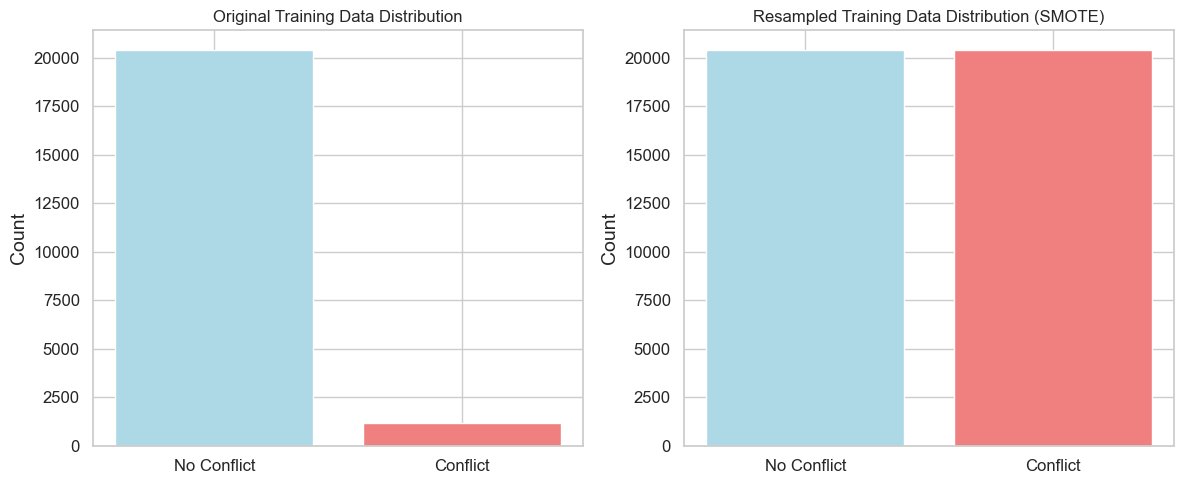

In [126]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=selected_features)

print(f"\nOriginal training set shape: {X_train.shape}")
print(f"Selected features training set shape: {X_train_selected.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Original training set conflict ratio: {100 * y_train.mean():.2f}%")
print(f"Resampled training set conflict ratio: {100 * y_train_resampled.mean():.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(['No Conflict', 'Conflict'], [len(y_train) - y_train.sum(), y_train.sum()], color=['lightblue', 'lightcoral'])
ax1.set_title('Original Training Data Distribution')
ax1.set_ylabel('Count')

ax2.bar(['No Conflict', 'Conflict'], [len(y_train_resampled) - y_train_resampled.sum(), y_train_resampled.sum()], color=['lightblue', 'lightcoral'])
ax2.set_title('Resampled Training Data Distribution (SMOTE)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

This pair of charts shows the class distribution before and after applying SMOTE:
- Left chart: Original training data with severe class imbalance (5.44% conflicts)
- Right chart: Resampled training data with balanced classes (50% conflicts)

# Model Selection, Training and Optimization


## 🌲 Decision Tree Classifier

### How It Works
Decision trees create a flowchart-like structure where:
- 🪓 Each **internal node** represents a test on a feature (e.g., "Are there more than 10 files changed?")
- 🛣️ Each **branch** represents the outcome of the test
- 🍃 Each **leaf node** represents a class label (conflict or no conflict)

### Key Hyperparameters Tuned
- **max_depth**: Controls the maximum depth of the tree, directly limiting model complexity. Deeper trees can capture more complex patterns but risk overfitting, while shallow trees provide simpler, more generalizable rules at the potential cost of underfitting.
- **min_samples_split**: Sets the minimum number of samples required to split an internal node. Higher values create more conservative trees that are less prone to capturing noise.
- **min_samples_leaf**: Specifies the minimum samples required in a leaf node, preventing the creation of very small leaves that might represent outliers rather than patterns.
- **class_weight**: Particularly crucial for our imbalanced dataset. The 'balanced' option weighs classes inversely proportional to their frequency, giving the minority class (conflicts) more importance during training.

### ⚖️ Strengths & Weaknesses
✅ **Pros**:
- Highly interpretable - can visualize the decision rules
- Handles both numerical and categorical features
- Captures feature interactions naturally
- Decision trees excel at capturing non-linear relationships between features like "number of files changed" and conflict likelihood

❌ **Cons**:
- Prone to overfitting, especially with deep trees
- Can be unstable (small data changes can result in very different trees)
- May struggle with highly imbalanced data without proper weighting

The grid search helps us find the optimal balance of these hyperparameters to maximize F1-score while controlling overfitting.


Performing grid search for Decision Tree hyperparameters...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best Decision Tree parameters for maximizing precision: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best precision score (5-fold CV): 0.9757

Decision Tree Evaluation:
Training Set Metrics:
  accuracy: 0.9937
  precision: 0.9983
  recall: 0.9892
  f1: 0.9937

Test Set Metrics:
  accuracy: 0.9616
  precision: 0.6426
  recall: 0.6667
  f1: 0.6544

Overfitting Analysis:
  accuracy difference (train-test): 0.0321
  precision difference (train-test): 0.3556
  recall difference (train-test): 0.3225
  f1 difference (train-test): 0.3393
⚠️ Warning: Potential overfitting detected in precision metric

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5101
           1       0.64      0.67      0.65       294

    accuracy                      

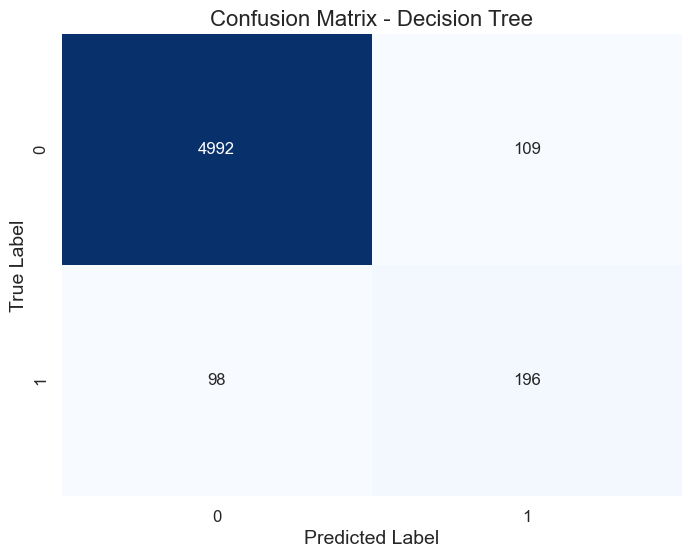

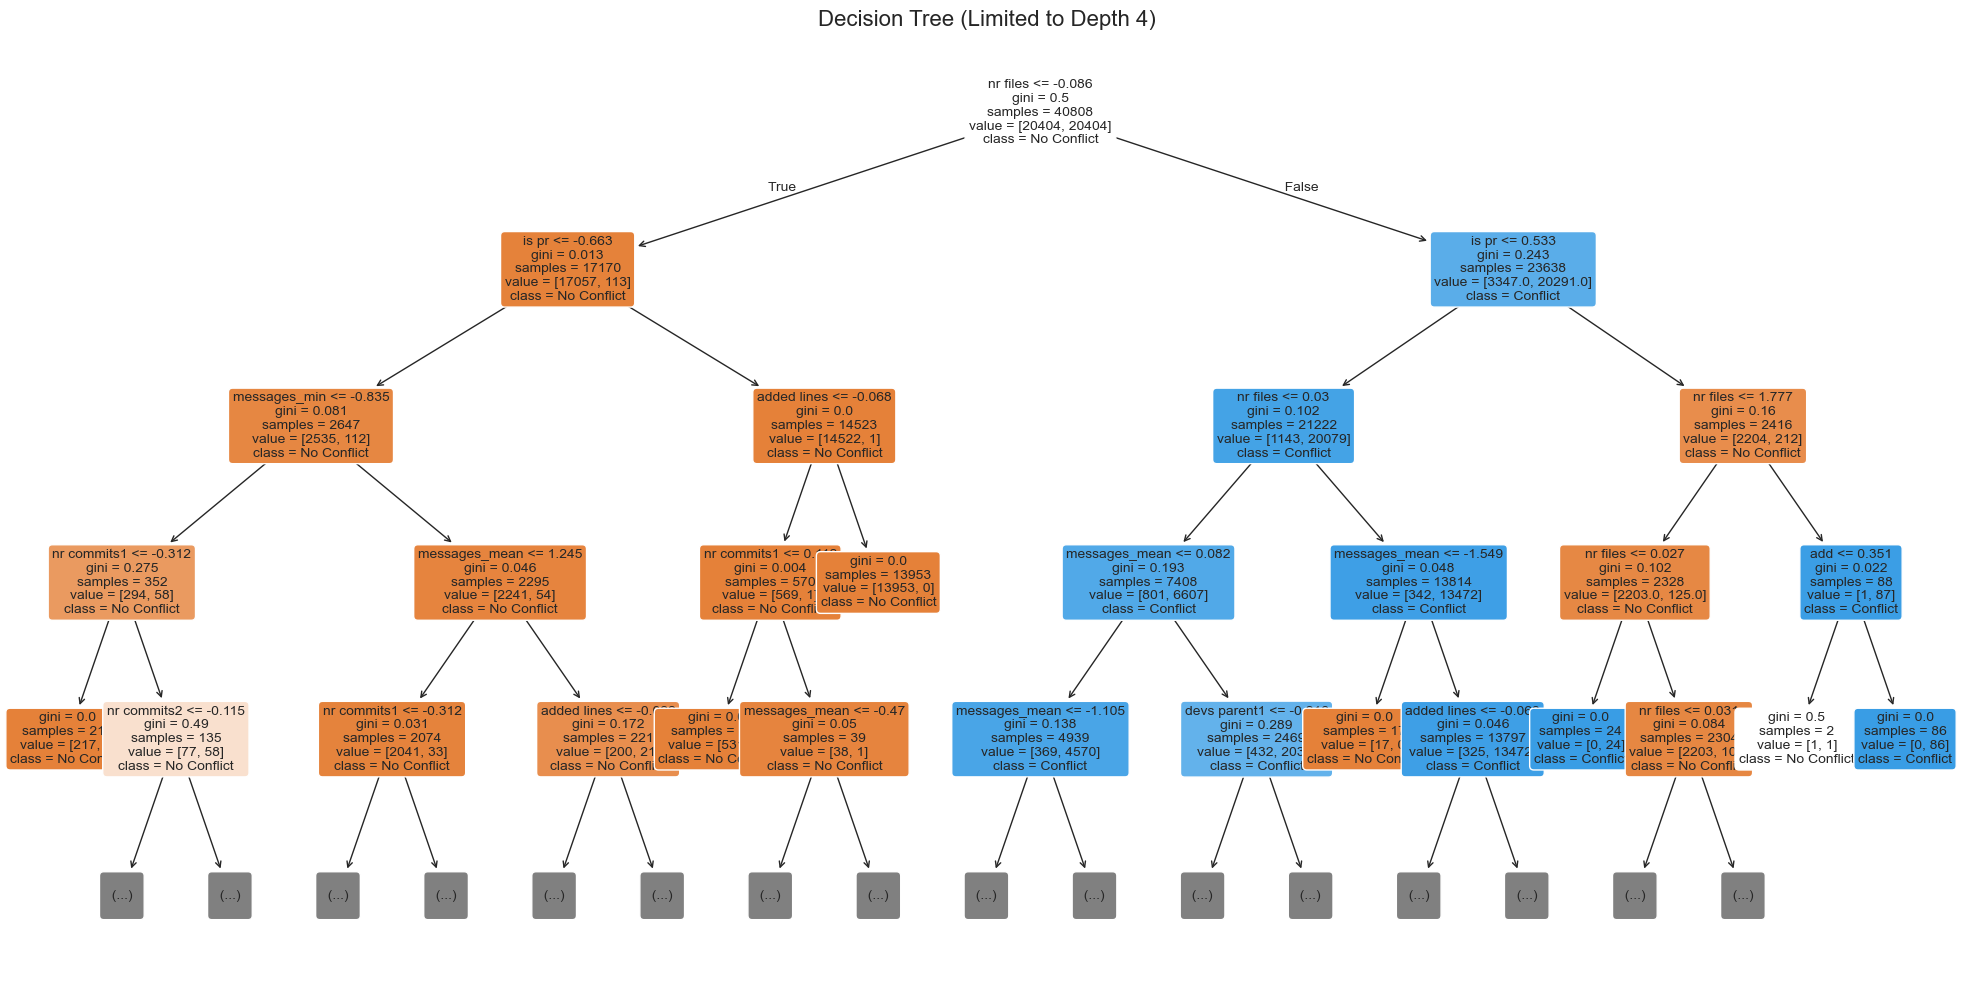

In [11]:
print("\nPerforming grid search for Decision Tree hyperparameters...")
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='precision',  
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_train_resampled, y_train_resampled)

print(f"\nBest Decision Tree parameters for maximizing precision: {dt_grid.best_params_}")
print(f"Best precision score (5-fold CV): {dt_grid.best_score_:.4f}")

best_dt = dt_grid.best_estimator_
dt_model, dt_train_metrics, dt_test_metrics = evaluate_model(
    best_dt, X_train_resampled, y_train_resampled, X_test_selected, y_test, "Decision Tree")

plt.figure(figsize=(20, 10))
max_depth_to_plot = min(4, best_dt.tree_.max_depth if best_dt.max_depth is None else best_dt.max_depth)
plot_tree(best_dt, 
          max_depth=max_depth_to_plot, 
          feature_names=selected_features, 
          class_names=['No Conflict', 'Conflict'], 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title(f'Decision Tree (Limited to Depth {max_depth_to_plot})', fontsize=16)
plt.tight_layout()
plt.show()

## 🧮 Naive Bayes Classifier (Gaussian)

### How It Works
Based on Bayes' theorem, this probabilistic classifier:
- 📊 Calculates the probability of each class given the feature values
- 🤔 Makes the "naive" assumption that features are conditionally independent
- 🔄 For continuous data, assumes features follow a Gaussian distribution

### Key Hyperparameters Tuned

The **var_smoothing** parameter adds a portion of the largest variance to all features, providing stability:
- Higher values increase the variance estimate, creating smoother decision boundaries
- Lower values stick closer to the empirical variance, potentially creating sharper boundaries
- Tuning this parameter helps balance model flexibility vs. stability

### Strengths & Weaknesses
✅ **Pros**:
- Very fast training and prediction
- Works well with high-dimensional data
- Needs less training data than more complex models
- Often performs surprisingly well despite simplistic assumptions

❌ **Cons**:
- "Naive" independence assumption rarely holds in real data
- May underperform when features have complex relationships
- Gaussian assumption may not be appropriate for all features


Performing grid search for Naive Bayes hyperparameters...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Naive Bayes parameters for maximizing precision: {'var_smoothing': 1e-09}
Best precision score (5-fold CV): 0.9401

Naive Bayes Evaluation:
Training Set Metrics:
  accuracy: 0.7133
  precision: 0.9405
  recall: 0.4554
  f1: 0.6137

Test Set Metrics:
  accuracy: 0.9377
  precision: 0.4281
  recall: 0.4252
  f1: 0.4266

Overfitting Analysis:
  accuracy difference (train-test): -0.2244
  precision difference (train-test): 0.5124
  recall difference (train-test): 0.0302
  f1 difference (train-test): 0.1870
⚠️ Warning: Potential overfitting detected in precision metric

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5101
           1       0.43      0.43      0.43       294

    accuracy                           0.94      5395
   macro avg       0.70      0.70      0.70      53

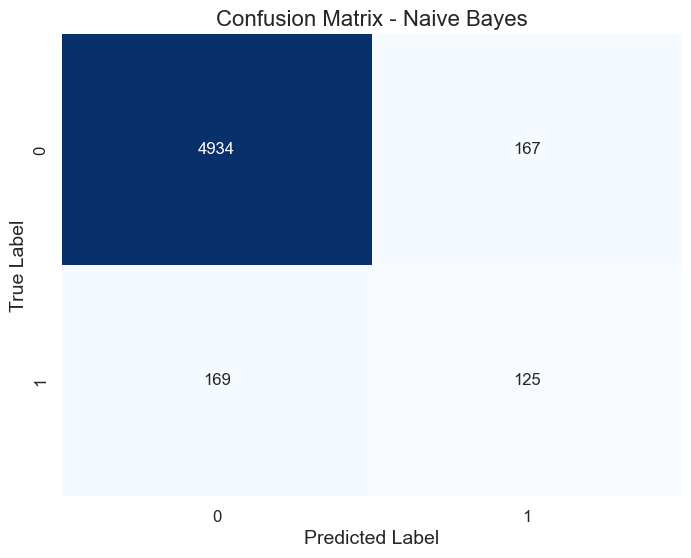

In [12]:
print("\nPerforming grid search for Naive Bayes hyperparameters...")
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

nb_grid = GridSearchCV(
    GaussianNB(),
    nb_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='precision', 
    n_jobs=-1,
    verbose=1
)

nb_grid.fit(X_train_resampled, y_train_resampled)

print(f"\nBest Naive Bayes parameters for maximizing precision: {nb_grid.best_params_}")
print(f"Best precision score (5-fold CV): {nb_grid.best_score_:.4f}")

best_nb = nb_grid.best_estimator_
nb_model, nb_train_metrics, nb_test_metrics = evaluate_model(
    best_nb, X_train_resampled, y_train_resampled, X_test_selected, y_test, "Naive Bayes")

## 🌲 Random Forest Classifier

### How It Works
Random Forests create an ensemble of decision trees through:
- 🎲 **Bagging**: Building many decision trees (controlled by **n_estimators**) on random subsets of training data (with replacement)
- 🔀 **Feature randomization**: Each tree considers only a random subset of features at each split, promoting diversity among trees
- 🗳️ **Voting**: Final prediction is determined by majority vote across all trees

### Key Hyperparameters Tuned
- **n_estimators**: Number of trees in the forest - more trees generally lead to better performance but with diminishing returns and increased computational cost
- **max_depth**: Maximum depth of each tree - this can be left higher than for single trees due to the ensemble's inherent resistance to overfitting
- **min_samples_split/leaf**: Controls the size of trees
- **bootstrap**:  Determines whether trees are built using bootstrap samples (sampling with replacement) - turning this off uses each data point exactly once across all trees, which can sometimes improve performance for smaller datasets

### Strengths & Weaknesses
✅ **Pros**:
- Reduces overfitting compared to single decision trees
- Robust to outliers and noise
- Provides feature importance measures, valuable for understanding conflict predictors
- Like decision trees, can handle features of different scales
- Individual trees can be built in parallel, improving training efficiency

❌ **Cons**:
- Less interpretable than a single decision tree, making it harder to explain specific predictions
- More computationally intensive 
- Requires more memory and storage
- Can be slower to train, especially with many trees and deep depths
- Performance can vary significantly with different hyperparameter settings

Random Forest often provides the best balance of performance and generalization for complex tasks like merge conflict prediction, as it combines the strength of multiple trees while overcoming individual tree limitations.


Performing grid search for Random Forest hyperparameters...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best Random Forest parameters for maximizing precision: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best precision score (5-fold CV): 0.9755

Random Forest Evaluation:
Training Set Metrics:
  accuracy: 0.9999
  precision: 0.9999
  recall: 0.9999
  f1: 0.9999

Test Set Metrics:
  accuracy: 0.9681
  precision: 0.6871
  recall: 0.7619
  f1: 0.7226

Overfitting Analysis:
  accuracy difference (train-test): 0.0318
  precision difference (train-test): 0.3128
  recall difference (train-test): 0.2379
  f1 difference (train-test): 0.2773
⚠️ Warning: Potential overfitting detected in precision metric

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5101
           1       0.69      0.76      0.72       294

    accuracy   

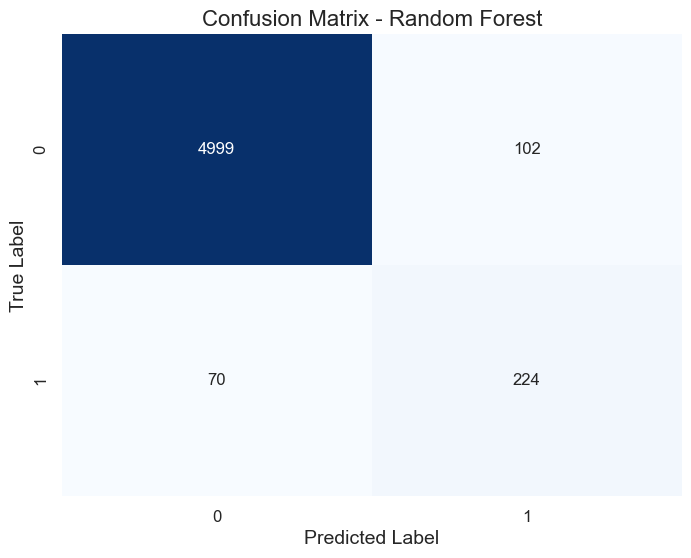

In [14]:
print("\nPerforming grid search for Random Forest hyperparameters...")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='precision', 
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_resampled, y_train_resampled)

print(f"\nBest Random Forest parameters for maximizing precision: {rf_grid.best_params_}")
print(f"Best precision score (5-fold CV): {rf_grid.best_score_:.4f}")

best_rf = rf_grid.best_estimator_
rf_model, rf_train_metrics, rf_test_metrics = evaluate_model(
    best_rf, X_train_resampled, y_train_resampled, X_test_selected, y_test, "Random Forest")

## 🚀 AdaBoost Classifier

### How It Works
AdaBoost (Adaptive Boosting) creates a strong classifier through:
- 🏋️ Training a sequence of weak learners (typically shallow decision trees) one after another
- ⚖️ Weighting examples: After each iteration, increases the weight of misclassified examples, forcing subsequent models to focus on the "hard cases"
- 🔄 Each new model focuses on the mistakes of previous models
- 🧮 Combining models with weighted voting: The final prediction is a weighted sum of all models, with better-performing models having more influence

### Key Hyperparameters Tuned
- **n_estimators**: Number of weak learners to train - more estimators can capture more complex patterns but may overfit and increase training time
- **learning_rate**: How quickly the algorithm adapts (smaller values need more estimators)
- **algorithm**: SAMME (discrete) or SAMME.R (real) boosting algorithms

### Strengths & Weaknesses
✅ **Pros**:
- Focuses on difficult examples - the adaptive weighting naturally gives more attention to hard-to-classify cases (like subtle conflict patterns)
- Less prone to overfitting than many other algorithms
- Can achieve high accuracy with simple base learners (e.g., shallow decision trees)
- Automatically identifies and focuses on boundary cases

❌ **Cons**:
- Sensitive to noisy data and outliers due to its focus on misclassified examples
- Sequential nature makes it slower and harder to parallelize
- Performance depends heavily on the quality of weak learners
- Requires careful tuning of learning rate and number of estimators

AdaBoost's focus on hard examples makes it particularly valuable for imbalanced classification tasks like conflict prediction, where correctly identifying the minority class is challenging but important.


Performing grid search for AdaBoost hyperparameters...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best AdaBoost parameters for maximizing precision: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 250}
Best precision score (5-fold CV): 0.9473

AdaBoost Evaluation:
Training Set Metrics:
  accuracy: 0.9660
  precision: 0.9473
  recall: 0.9870
  f1: 0.9667

Test Set Metrics:
  accuracy: 0.9490
  precision: 0.5176
  recall: 0.9490
  f1: 0.6699

Overfitting Analysis:
  accuracy difference (train-test): 0.0170
  precision difference (train-test): 0.4296
  recall difference (train-test): 0.0380
  f1 difference (train-test): 0.2969
⚠️ Warning: Potential overfitting detected in precision metric

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      5101
           1       0.52      0.95      0.67       294

    accuracy                           0.95      5395
   macro avg       0

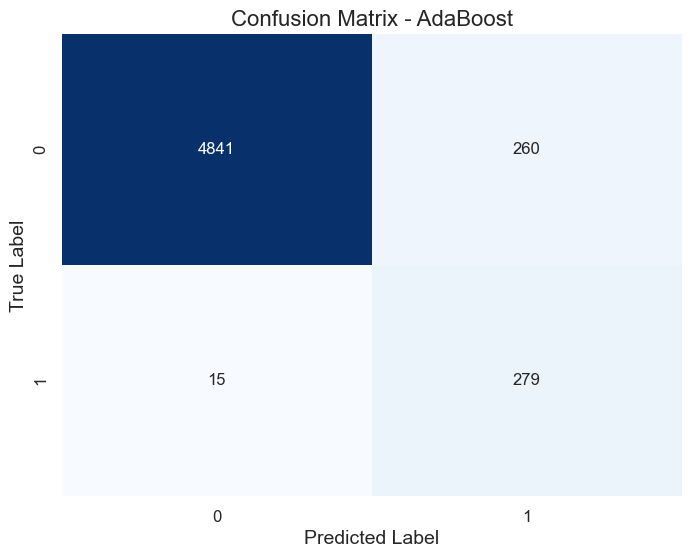

In [86]:
print("\nPerforming grid search for AdaBoost hyperparameters...")
ada_param_grid = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.1, 0.15, 0.2],
    'algorithm': ['SAMME']
}

ada_grid = GridSearchCV(
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2, random_state=42), 
        random_state=42
    ),
    ada_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='precision', 
    n_jobs=-1,
    verbose=1
)

ada_grid.fit(X_train_resampled, y_train_resampled)

print(f"\nBest AdaBoost parameters for maximizing precision: {ada_grid.best_params_}")
print(f"Best precision score (5-fold CV): {ada_grid.best_score_:.4f}")

best_ada = ada_grid.best_estimator_
ada_model, ada_train_metrics, ada_test_metrics = evaluate_model(
    best_ada, X_train_resampled, y_train_resampled, X_test_selected, y_test, "AdaBoost")

# 📊 Model Comparison 


Model Comparison (Test Set Performance):
               Precision    Recall  F1 Score  Accuracy
Random Forest   0.687117  0.761905  0.722581  0.968119
Decision Tree   0.642623  0.666667  0.654424  0.961631
AdaBoost        0.517625  0.948980  0.669868  0.949027
Naive Bayes     0.428082  0.425170  0.426621  0.937720


<Figure size 1200x800 with 0 Axes>

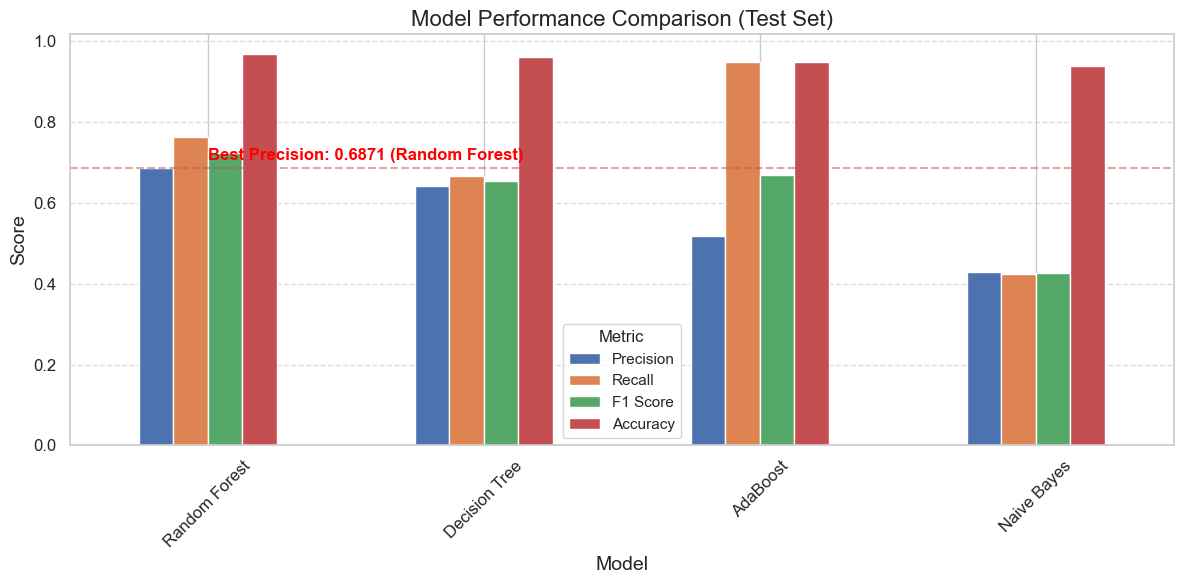

🏆 Best model for precision: Random Forest
📊 Current precision: 0.6871


In [87]:
models = {
    'Decision Tree': dt_test_metrics,
    'Naive Bayes': nb_test_metrics,
    'Random Forest': rf_test_metrics,
    'AdaBoost': ada_test_metrics
}

comparison_df = pd.DataFrame({
    model_name: {
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1'],
        'Accuracy': metrics['accuracy']
    }
    for model_name, metrics in models.items()
}).T

comparison_df = comparison_df.sort_values('Precision', ascending=False)
print("\nModel Comparison (Test Set Performance):")
print(comparison_df)

plt.figure(figsize=(12, 8))
ax = comparison_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison (Test Set)', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')

best_model = comparison_df.index[0]
best_precision = comparison_df.loc[best_model, 'Precision']
plt.axhline(y=best_precision, color='r', linestyle='--', alpha=0.5)
plt.text(0, best_precision + 0.02, f'Best Precision: {best_precision:.4f} ({best_model})', 
         color='red', fontweight='bold')

plt.tight_layout()
plt.show()

best_models = {
    'Decision Tree': best_dt,
    'Naive Bayes': best_nb, 
    'Random Forest': best_rf,
    'AdaBoost': best_ada
}

best_model_name = comparison_df.index[0] 

print(f"🏆 Best model for precision: {best_model_name}")
print(f"📊 Current precision: {comparison_df.loc[best_model_name, 'Precision']:.4f}")

# 🎯 Precision Optimization


The **default classification threshold is 0.5**, meaning any prediction probability ≥ 0.5 is classified as a conflict (it assumes equal cost for false positives and false negatives). However, we can optimize this threshold to maximize precision.

**Why Threshold Tuning Works for Precision:**
- By increasing the threshold (e.g., to 0.7 or 0.8), we become more conservative
- Only predictions with very high confidence are classified as conflicts
- This reduces false positives, directly improving precision
- Trade-off: We may miss some conflicts (lower recall) but those we catch are more reliable

In [ ]:
def optimize_threshold_for_precision(model, X_test, y_test, model_name, min_recall=0.25):
    """
    Find the optimal threshold that maximizes precision while maintaining minimum recall
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    
    valid_recall_mask = recalls >= min_recall
    
    if not np.any(valid_recall_mask):
        print(f"⚠️ Warning: Cannot achieve minimum recall of {min_recall:.2f} for {model_name}")
        print(f"   Using default threshold 0.5")
        return 0.5, model.predict(X_test)
    
    valid_precisions = precisions[valid_recall_mask]
    valid_thresholds = thresholds[valid_recall_mask]
    
    max_precision_idx = np.argmax(valid_precisions)
    optimal_threshold = valid_thresholds[max_precision_idx]
    optimal_precision = valid_precisions[max_precision_idx]
    
    y_pred_optimized = (y_proba >= optimal_threshold).astype(int)
    
    print(f"\n📊 {model_name} Threshold Optimization:")
    print(f"   Default threshold (0.5) precision: {precision_score(y_test, model.predict(X_test)):.4f}")
    print(f"   Optimal threshold: {optimal_threshold:.4f}")
    print(f"   Optimized precision: {optimal_precision:.4f}")
    
    return optimal_threshold, y_pred_optimized


📊 Decision Tree Threshold Optimization:
   Default threshold (0.5) precision: 0.6426
   Optimal threshold: 1.0000
   Optimized precision: 0.6608

📊 Naive Bayes Threshold Optimization:
   Default threshold (0.5) precision: 0.4281
   Optimal threshold: 0.9998
   Optimized precision: 0.4896

📊 Random Forest Threshold Optimization:
   Default threshold (0.5) precision: 0.6871
   Optimal threshold: 0.9400
   Optimized precision: 0.9390

📊 AdaBoost Threshold Optimization:
   Default threshold (0.5) precision: 0.5176
   Optimal threshold: 0.7322
   Optimized precision: 0.8163


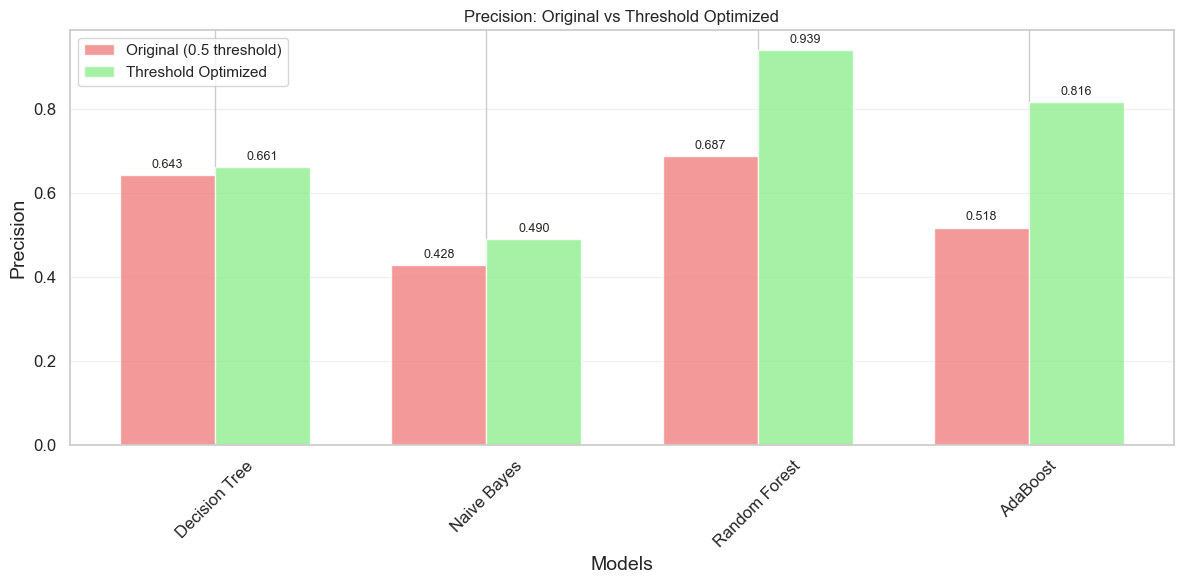

In [125]:
optimized_results = {}
optimal_thresholds = {}

model_dict = {
    'Decision Tree': best_dt,
    'Naive Bayes': best_nb, 
    'Random Forest': best_rf,
    'AdaBoost': best_ada
}

for model_name, model in model_dict.items():
    optimal_threshold, y_pred_opt = optimize_threshold_for_precision(
        model, X_test_selected, y_test, model_name, min_recall=0.25
    )
    
    optimized_results[model_name] = {
        'threshold': optimal_threshold,
        'precision': precision_score(y_test, y_pred_opt),
        'recall': recall_score(y_test, y_pred_opt),
        'f1': f1_score(y_test, y_pred_opt),
        'accuracy': accuracy_score(y_test, y_pred_opt)
    }
    
    optimal_thresholds[model_name] = optimal_threshold

optimized_df = pd.DataFrame({
    model_name: {
        'Threshold': results['threshold'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1 Score': results['f1'],
        'Accuracy': results['accuracy']
    }
    for model_name, results in optimized_results.items()
}).T

optimized_df = optimized_df.sort_values('Precision', ascending=False)

plt.figure(figsize=(12, 6))

models_list = ['Decision Tree', 'Naive Bayes', 'Random Forest', 'AdaBoost']
original_precisions = [comparison_df.loc[model, 'Precision'] for model in models_list]
optimized_precisions = [optimized_df.loc[model, 'Precision'] for model in models_list]

x = np.arange(len(models_list))
width = 0.35

bars1 = plt.bar(x - width/2, original_precisions, width, label='Original (0.5 threshold)', alpha=0.8, color='lightcoral')
bars2 = plt.bar(x + width/2, optimized_precisions, width, label='Threshold Optimized', alpha=0.8, color='lightgreen')

plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision: Original vs Threshold Optimized')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)
             
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

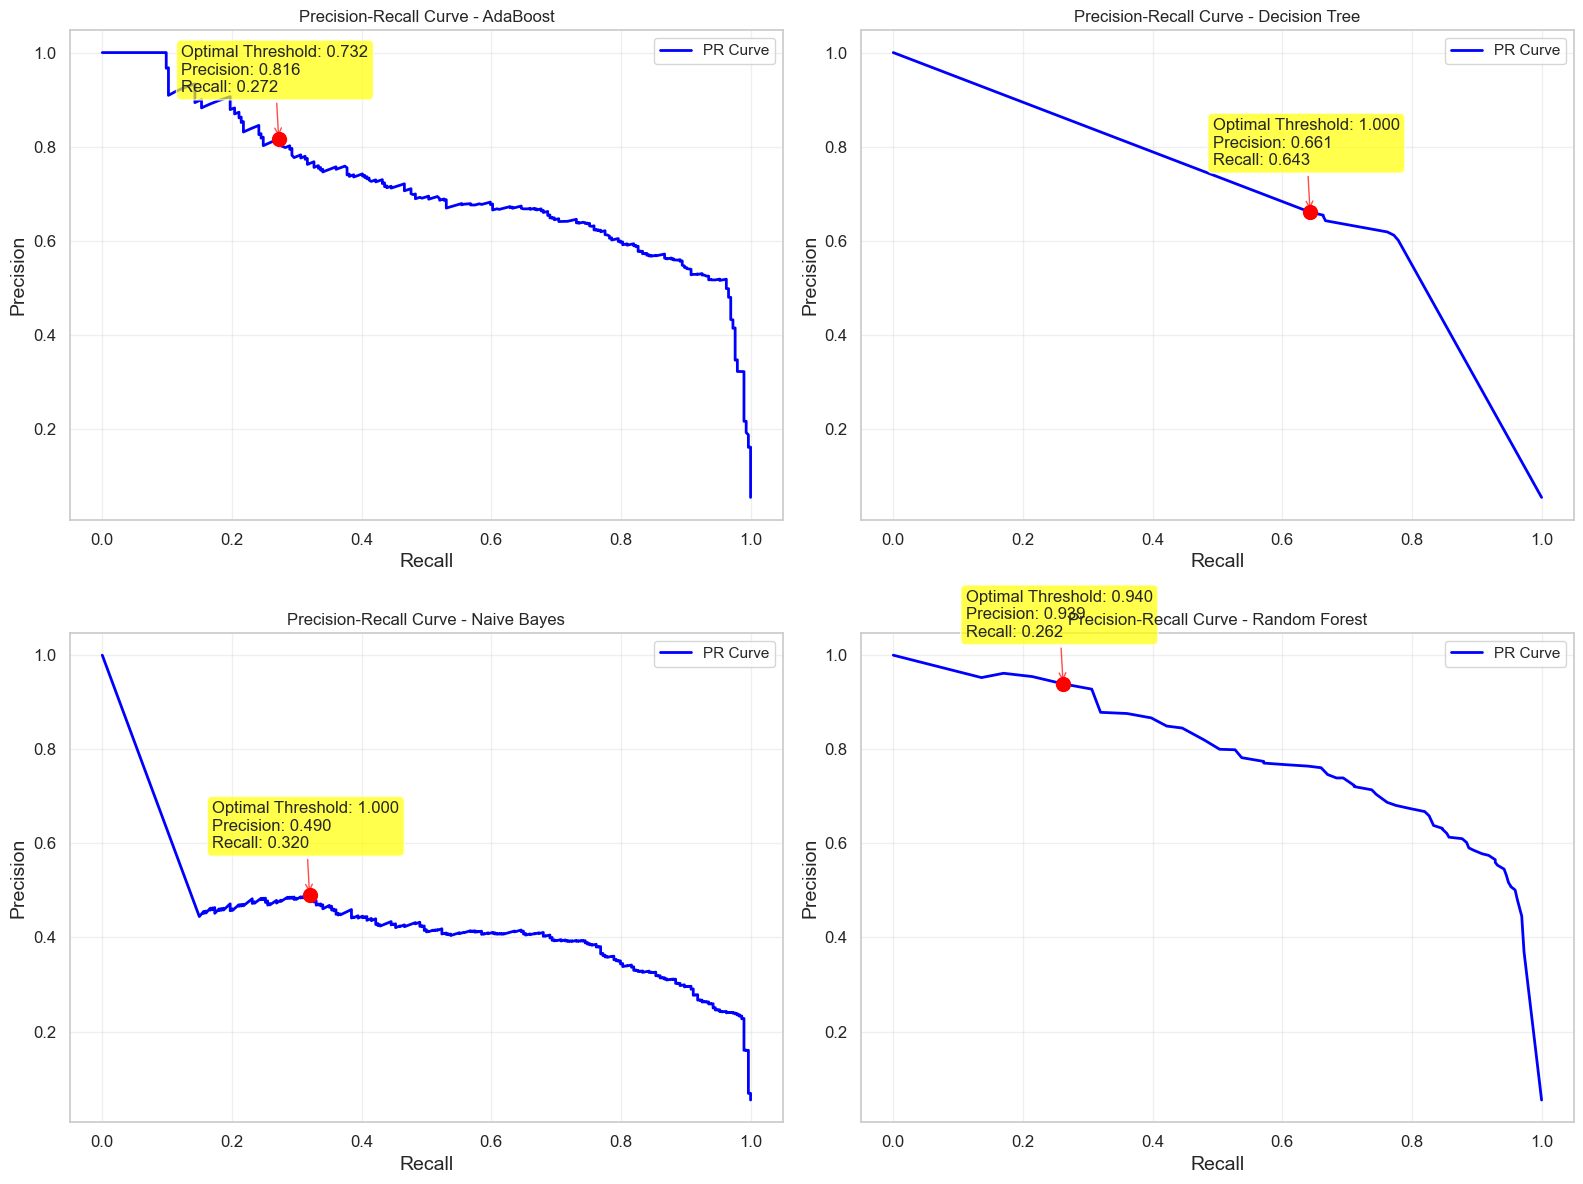

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten() 

models = {
    'AdaBoost': best_ada,
    'Decision Tree': best_dt,
    'Naive Bayes': best_nb,
    'Random Forest': best_rf
}

for ax, (model_name, model) in zip(axes, models.items()):
    y_proba = model.predict_proba(X_test_selected)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    ax.plot(recall, precision, linewidth=2, color='blue', label='PR Curve')
    
    if model_name in optimal_thresholds:
        optimal_thresh = optimal_thresholds[model_name]
        optimal_precision = optimized_df.loc[model_name, 'Precision'] 
        optimal_recall = optimized_df.loc[model_name, 'Recall']
        
        ax.scatter(optimal_recall, optimal_precision, color='red', s=100, zorder=5)
        ax.annotate(f'Optimal Threshold: {optimal_thresh:.3f}\nPrecision: {optimal_precision:.3f}\nRecall: {optimal_recall:.3f}',
                   xy=(optimal_recall, optimal_precision), 
                   xytext=(optimal_recall-0.15, optimal_precision+0.1),
                   arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {model_name}')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


🏆 BEST PRECISION-OPTIMIZED MODEL: Random Forest
   Precision: 0.9390
   Optimal Threshold: 0.9400
   Recall: 0.2619
   F1-Score: 0.4096


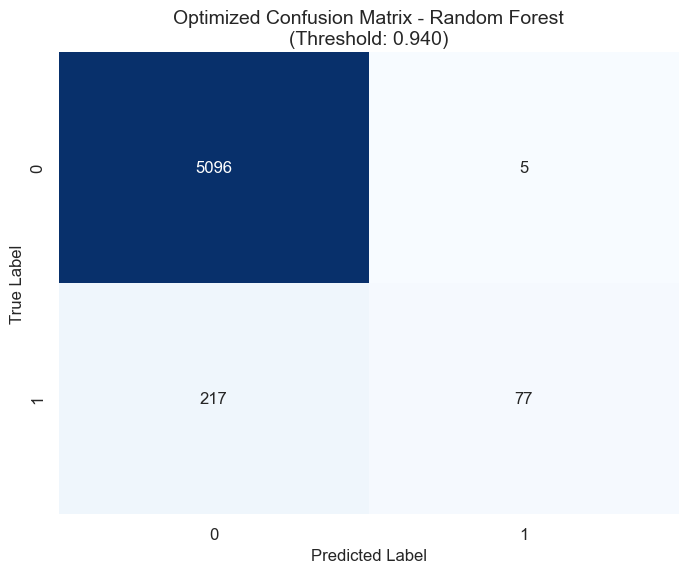

💼 IMPACT OF THRESHOLD OPTIMIZATION
With optimized threshold (0.940):
✅ True Positives (Conflicts Correctly Identified): 77
❌ False Positives (False Alarms): 5
⚠️  False Negatives (Missed Conflicts): 217
✅ True Negatives (Correctly Identified Non-Conflicts): 5096

📈 Key Metrics:
False Alarm Rate: 0.10%
Conflict Detection Rate: 26.19%
Precision (Reliability of Predictions): 93.90%

🎯 Recommendation:
Use Random Forest with threshold 0.940 for maximum precision.
This configuration achieves 93.9% precision, meaning 93.9% of predicted conflicts will be actual conflicts, minimizing false alarms.


In [123]:
best_optimized_model = optimized_df.index[0]
best_optimized_precision = optimized_df.loc[best_optimized_model, 'Precision']
best_optimized_threshold = optimal_thresholds[best_optimized_model]

print(f"\n🏆 BEST PRECISION-OPTIMIZED MODEL: {best_optimized_model}")
print(f"   Precision: {best_optimized_precision:.4f}")
print(f"   Optimal Threshold: {best_optimized_threshold:.4f}")
print(f"   Recall: {optimized_df.loc[best_optimized_model, 'Recall']:.4f}")
print(f"   F1-Score: {optimized_df.loc[best_optimized_model, 'F1 Score']:.4f}")

best_model_final = {'Decision Tree': best_dt, 'Naive Bayes': best_nb, 
                   'Random Forest': best_rf, 'AdaBoost': best_ada}[best_optimized_model]

y_proba_final = best_model_final.predict_proba(X_test_selected)[:, 1]
y_pred_final_optimized = (y_proba_final >= best_optimized_threshold).astype(int)

plt.figure(figsize=(8, 6))
cm_optimized = confusion_matrix(y_test, y_pred_final_optimized)
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Optimized Confusion Matrix - {best_optimized_model}\n(Threshold: {best_optimized_threshold:.3f})', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

tn, fp, fn, tp = cm_optimized.ravel()

print("💼 IMPACT OF THRESHOLD OPTIMIZATION")
print(f"With optimized threshold ({best_optimized_threshold:.3f}):")
print(f"✅ True Positives (Conflicts Correctly Identified): {tp}")
print(f"❌ False Positives (False Alarms): {fp}")
print(f"⚠️  False Negatives (Missed Conflicts): {fn}")
print(f"✅ True Negatives (Correctly Identified Non-Conflicts): {tn}")

false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
conflict_detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📈 Key Metrics:")
print(f"False Alarm Rate: {false_alarm_rate:.2%}")
print(f"Conflict Detection Rate: {conflict_detection_rate:.2%}")
print(f"Precision (Reliability of Predictions): {best_optimized_precision:.2%}")

print(f"\n🎯 Recommendation:")
print(f"Use {best_optimized_model} with threshold {best_optimized_threshold:.3f} for maximum precision.")
print(f"This configuration achieves {best_optimized_precision:.1%} precision, meaning {best_optimized_precision:.1%} of predicted conflicts will be actual conflicts, minimizing false alarms.")


In [124]:
print("📊 INITIAL vs OPTIMIZED PERFORMANCE COMPARISON")

print(f"\n{'Model':<15} {'Metric':<10} {'Initial':<8} {'Optimized':<10} {'Change':<10} {'Change %':<10} {'Threshold'}")
print("-" * 80)

for model_name in models_list:
    init_prec = comparison_df.loc[model_name, 'Precision']
    opt_prec = optimized_df.loc[model_name, 'Precision']
    init_rec = comparison_df.loc[model_name, 'Recall']
    opt_rec = optimized_df.loc[model_name, 'Recall']
    init_f1 = comparison_df.loc[model_name, 'F1 Score']
    opt_f1 = optimized_df.loc[model_name, 'F1 Score']
    
    prec_change = opt_prec - init_prec
    rec_change = opt_rec - init_rec
    prec_pct = (prec_change / init_prec) * 100
    rec_pct = (rec_change / init_rec) * 100
    f1_change = opt_f1 - init_f1
    f1_pct = (f1_change / init_f1) * 100

    optimal_threshold = optimal_thresholds[model_name]
  
    print(f"{model_name:<15} {'Precision':<10} {init_prec:<8.4f} {opt_prec:<10.4f} {prec_change:<+10.4f} {prec_pct:+6.1f}% {'':>5} {optimal_threshold:.4f}")
    print(f"{'':<15} {'Recall':<10} {init_rec:<8.4f} {opt_rec:<10.4f} {rec_change:<+10.4f} {rec_pct:+6.1f}% {'':>5} {'(same)'}")
    print(f"{'':<15} {'F1 Score':<10} {init_f1:<8.4f} {opt_f1:<10.4f} {f1_change:<+10.4f} {f1_pct:+6.1f}% {'':>5} {'(same)'}")
    print("-" * 80)

avg_prec_improvement = np.mean([optimized_df.loc[m, 'Precision'] - comparison_df.loc[m, 'Precision'] for m in models_list])
avg_rec_change = np.mean([optimized_df.loc[m, 'Recall'] - comparison_df.loc[m, 'Recall'] for m in models_list])
avg_f1_change = np.mean([optimized_df.loc[m, 'F1 Score'] - comparison_df.loc[m, 'F1 Score'] for m in models_list])

print(f"\n📈 SUMMARY:")
print(f"Average Precision Improvement: +{avg_prec_improvement:.4f}")
print(f"Average Recall Change: {avg_rec_change:+.4f}")
print(f"Average F1 Score Change: {avg_f1_change:+.4f}")
print(f"Best Overall: {optimized_df.index[0]} (Precision: {optimized_df.iloc[0]['Precision']:.4f})")


📊 INITIAL vs OPTIMIZED PERFORMANCE COMPARISON

Model           Metric     Initial  Optimized  Change     Change %   Threshold
--------------------------------------------------------------------------------
Decision Tree   Precision  0.6426   0.6608     +0.0182      +2.8%       1.0000
                Recall     0.6667   0.6429     -0.0238      -3.6%       (same)
                F1 Score   0.6544   0.6517     -0.0027      -0.4%       (same)
--------------------------------------------------------------------------------
Naive Bayes     Precision  0.4281   0.4896     +0.0615     +14.4%       0.9998
                Recall     0.4252   0.3197     -0.1054     -24.8%       (same)
                F1 Score   0.4266   0.3868     -0.0398      -9.3%       (same)
--------------------------------------------------------------------------------
Random Forest   Precision  0.6871   0.9390     +0.2519     +36.7%       0.9400
                Recall     0.7619   0.2619     -0.5000     -65.6%       (same)

## 🎯 Multi-Threshold Ensemble Strategy

After implementing the initial optimization, I realized that different scenarios require different trade-offs, that's why a multi-threshold strategy is needed. 

In [93]:
def create_multi_threshold_ensemble(model, X_test, y_test, model_name):
    """
    Create ensemble with multiple thresholds to balance precision and recall
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    results = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'balance_score': 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        })
    
    best_balance = max(results, key=lambda x: x['f1'])
    best_precision = max(results, key=lambda x: x['precision'])

    print(f"\n📊 {model_name} Multi-Threshold Analysis:")
    print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 45)
    for result in results:
        marker1 = "🏆" if result['threshold'] == best_balance['threshold'] else ""
        marker2 = "🎯" if result['threshold'] == best_precision['threshold'] else ""
        print(f"{result['threshold']:<10.1f} {result['precision']:<10.4f} {result['recall']:<10.4f} {result['f1']:<10.4f}{marker1}")
        print(f"{'':<10} {'':<10} {'':<10} {result['balance_score']:<10.4f}{marker2}")
        print("-" * 45)
        
    return best_balance

balanced_results = {}
for model_name in ['Random Forest', 'Decision Tree', 'Naive Bayes', 'AdaBoost']:
    model = model_dict[model_name]
    balanced_results[model_name] = create_multi_threshold_ensemble(
        model, X_test_selected, y_test, model_name
    )



📊 Random Forest Multi-Threshold Analysis:
Threshold  Precision  Recall     F1-Score  
---------------------------------------------
0.1        0.5091     0.9524     0.6635    
                                 0.6635    
---------------------------------------------
0.2        0.5594     0.9286     0.6982    
                                 0.6982    
---------------------------------------------
0.3        0.5905     0.8878     0.7092    
                                 0.7092    
---------------------------------------------
0.4        0.6320     0.8469     0.7238    
                                 0.7238    
---------------------------------------------
0.5        0.6806     0.7755     0.7250    🏆
                                 0.7250    
---------------------------------------------
0.6        0.7391     0.6939     0.7158    
                                 0.7158    
---------------------------------------------
0.7        0.7672     0.6054     0.6768    
                  

### Key Discoveries

- **Random Forest**:
    - Best F1-Score at threshold = 0.5 (🏆): Precision = 0.6806, Recall = 0.7755, F1 = 0.7250. This point gives the best balance between precision and recall.
    - Precision increases with threshold (from 0.5091 → 0.9524), but comes with a massive drop in recall at high thresholds (0.1361).
    - Extreme high thresholds (0.9–1.0) result in high precision nut very poor recall and F1.
    - Too low thresholds (0.1) give high recall (0.95) but poor precision (0.50).

- **Decision Tree**:
    - Best F1-Score at threshold = 0.4-0.5 (🏆), slightly favoring recall while maintaining decent precision.
    - Precision starts at 0.6010 and climbs gradually to 0.6608 by threshold 0.8+, then remains there.
    - More stable performance across thresholds.
    - Less sensitive to threshold changes compared to Random Forest.

- **Naive Bayes**:
    - Best F1-Score at threshold = 0.1 (🏆)
    - Performance is generally low across thresholds (~0.428 to 0.445).
    - Precision barely increases as threshold rises, but recall drops quickly.

- **AdaBoost**:
    - Best F1-Score at threshold = 0.6 (🏆)
    - Very high recall at low thresholds (e.g., 0.9762 at 0.3) but poor precision.
    - Sudden collapse in performance after 0.7.
    - Thresholds > 0.8 lead to precision-only predictions (but no recall), resulting in zero F1.

Random Forest benefits most from a balanced threshold (0.5); it’s sensitive to changes and exhibits a typical precision-recall trade-off.

Decision Tree is robust to threshold shifts, giving flexibility in tuning without sharp drops in F1.

Naive Bayes has low baseline performance and quickly loses recall as thresholds increase, making it risky to raise the threshold too much.

AdaBoost performs best at moderate thresholds. It suffers from sharp performance cliffs at higher thresholds due to its sensitivity to probability calibration.